In [20]:
import importlib
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import healpix_utils

ERROR! Session/line number was not unique in database. History logging moved to new session 2568


In [21]:
importlib.reload(healpix_utils)

<module 'healpix_utils' from '/home/m/m301021/add-CloudClimato-team/hk25-CloudClimato/healpix_utils.py'>

In [22]:
cat_hk25 = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")['EU']
cat_nextgems = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")["ICON"]

In [23]:
print(list(cat_hk25))

['CERES_EBAF', 'ERA5', 'IR_IMERG', 'JRA3Q', 'MERRA2', 'casesm2_10km_nocumulus', 'icon_d3hp003', 'icon_d3hp003aug', 'icon_d3hp003feb', 'icon_ngc4008', 'ifs_tco2559_rcbmf', 'ifs_tco3999-ng5_deepoff', 'ifs_tco3999-ng5_rcbmf', 'ifs_tco3999-ng5_rcbmf_cf', 'ifs_tco3999_rcbmf', 'nicam_gl11', 'scream-dkrz', 'tracking-d3hp003', 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest', 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest', 'um_glm_n1280_CoMA9_TBv1p2', 'um_glm_n1280_GAL9', 'um_glm_n2560_RAL3p3']


In [24]:
print(list(cat_nextgems))

['ngc4008a', 'ngc4008', 'ngc4007', 'ngc4006', 'ngc4005', 'ngc3028', 'ngc3028_bc_land', 'ngc3026_WILL_BE_DELETED', 'HAMOCC', 'ngc3542', 'erc1011', 'erc1017', 'C5', 'PrecipPuzzle', 'ngc5004']


# Global variables

In [25]:
zoom = 6 # # https://easy.gems.dkrz.de/Processing/healpix/index.html 
deg = 1 # degree for regridded cell
idx = healpix_utils.get_nn_lon_lat_index(
    2**zoom, np.linspace(0+deg/2, 360-deg/2, int(360/deg)), 
    np.linspace(-90+deg/2, 90-deg/2, int(180/deg))
)

# ICON 

In [27]:
icon_simulations = {"ngc3028": {"long_name": "ICON cyc3"}, 
                    "icon_ngc4008": {"long_name": "ICON cyc4"},
              "icon_d3hp003": {"long_name": "ICON cyc5"}}

In [51]:
pd.DataFrame(cat_hk25["icon_d3hp003"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT1H, PT3H, PT6H, P1D]",P1D
1,time_method,time subsetting method,str,"[mean, inst]",mean
2,zoom,zoom resolution of the dataset,int,"[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",0


In [52]:
interesting_variables = ["tas", "prw", 
                         "clivi", "cllvi", 'clwvi', "pr",
                         "rsdt",  "rsut",  "rlut"] 

In [10]:
%%time
for simu_name in list(icon_simulations.keys()): 
    if simu_name == "ngc3028": 
        cat = cat_nextgems 
    else: 
        cat = cat_hk25
    icon = cat[simu_name](zoom=zoom).to_dask()
    
    icon = icon[[v for v in interesting_variables if v in list(icon.data_vars)]]
    if 'clwvi' in icon.data_vars:
        icon = icon.rename({'clwvi': 'cllvi'})
    icon["pr"] = (icon.pr*3600*24/1000*1000) # conversion to mm 
    icon = icon.sel(time=slice("2020-03-01", "2031-01-01")) # remove 1st 2 month spin-up 
    icon_latprof = icon.isel(cell=idx).mean(["lon", "time"])
    icon_simulations[simu_name]['latprof'] = icon_latprof.compute()

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension nam

CPU times: user 3min 47s, sys: 1min 58s, total: 5min 46s
Wall time: 7min 17s


In [35]:
for simu_name in list(icon_simulations.keys()): 
    icon_simulations[simu_name]['latprof'].to_netcdf(f'/work/bb1153/m301021/hk25/LatProf_{simu_name}_2020_.nc')

In [28]:
for simu_name in list(icon_simulations.keys()): 
    icon_simulations[simu_name]['latprof'] = xr.open_dataset(f'/work/bb1153/m301021/hk25/LatProf_{simu_name}_2020_.nc')

# IFS

In [29]:
zoom_ifs = 7

In [30]:
ifs_simulations = {"ifs_tco2559_rcbmf": {"long_name": "IFS 9km"}, 
                    "ifs_tco3999-ng5_rcbmf": {"long_name": "IFS 2.8km"},
              "ifs_tco3999-ng5_deepoff": {"long_name": "IFS 2.8km (deepOFF)"}}

In [18]:
pd.DataFrame(cat_hk25["ifs_tco2559_rcbmf"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT1H, P1D, P1M]",PT1H
1,zoom,zoom level of the dataset,int,"[7, 10]",7


In [61]:
cat_hk25["ifs_tco2559_rcbmf"].to_dask()

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 3TB
Dimensions:     (time: 10201, value: 196608, crs: 1, level_soil: 4, level: 19)
Coordinates:
  * crs         (crs) float32 4B nan
    lat         (value) float64 2MB dask.array<chunksize=(196608,), meta=np.ndarray>
  * level_soil  (level_soil) int64 32B 1 2 3 4
    lon         (value) float64 2MB dask.array<chunksize=(196608,), meta=np.ndarray>
  * time        (time) datetime64[ns] 82kB 2020-01-01 ... 2021-03-01
  * level       (level) int64 152B 1 5 10 20 30 50 ... 500 600 700 850 925 1000
Dimensions without coordinates: value
Data variables: (12/53)
    10si        (time, value) float64 16GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    10u         (time, value) float64 16GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    10v         (time, value) float64 16GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    2d          (time, value) float64 16GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    2sh         (time, value) float64 16GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    2t          (time, value) float64 16GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    ...          ...
    r           (time, level, value) float64 305GB dask.array<chunksize=(1, 1, 196608), meta=np.ndarray>
    t           (time, level, value) float64 305GB dask.array<chunksize=(1, 1, 196608), meta=np.ndarray>
    u           (time, level, value) float64 305GB dask.array<chunksize=(1, 1, 196608), meta=np.ndarray>
    v           (time, level, value) float64 305GB dask.array<chunksize=(1, 1, 196608), meta=np.ndarray>
    w           (time, level, value) float64 305GB dask.array<chunksize=(1, 1, 196608), meta=np.ndarray>
    z           (time, level, value) float64 305GB dask.array<chunksize=(1, 1, 196608), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [19]:
idx_ifs  = healpix_utils.get_nn_lon_lat_index(
    2**zoom_ifs, np.linspace(0+deg/2, 360-deg/2, int(360/deg)), 
    np.linspace(-90+deg/2, 90-deg/2, int(180/deg))
)

In [20]:
interesting_variables = ["2t", "tcwv", 
                         "tcc",  "tciw", "tclw", 'tp',
                         "tisr", "tsr", "tsrc", "ttr", 'ttrc'] 

In [ ]:
%%time
for simu_name in list(ifs_simulations.keys()): 
    ifs = cat_hk25[simu_name](zoom=zoom_ifs, time='PT1H').to_dask()
    ifs = ifs[interesting_variables]
    ifs['tsr'] = ifs.tisr - ifs.tsr
    ifs = ifs.rename({'tsr': 'rsut',
                        'ttr': 'rlut', 
                        'tisr': 'rsdt',
                       '2t': 'tas', 
                       'tcwv': 'prw', 
                       'tciw': 'clivi', 
                       'tclw': 'cllvi', 
                        'tp': 'pr'
                       })
    ifs = ifs.sel(time=slice("2020-03-01", "2031-01-1"))
    ifs_latprof = ifs.drop_vars(["lat", "lon"]).isel(value=idx_ifs).mean(["lon", "time"])
    ifs_latprof['rlut'] = - ifs_latprof.rlut / (3600) # to convert to W m-2
    ifs_latprof['rsut'] = ifs_latprof.rsut / (3600) # to convert to W m-2
    ifs_latprof['pr'] = ifs_latprof.pr * 1000 * 24  # to convert to mm per day  
    ifs_simulations[simu_name]['latprof'] = ifs_latprof.compute() 

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [ ]:
for simu_name in list(ifs_simulations.keys()): 
    ifs_simulations[simu_name]['latprof'].to_netcdf(f'/work/bb1153/m301021/hk25/LatProf_{simu_name}_2020_.nc')

In [31]:
for simu_name in list(ifs_simulations.keys()): 
    ifs_simulations[simu_name]['latprof']=xr.open_dataset(f'/work/bb1153/m301021/hk25/LatProf_{simu_name}_2020_.nc')

# ERA5

In [32]:
pd.DataFrame(cat_hk25["ERA5"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[8, 7, 6, 5, 4, 3, 2, 1, 0]",7


In [33]:
era5 = cat_hk25['ERA5'](zoom=zoom).to_dask()

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [34]:
interesting_variables = ["2t", "tcwv", 
                         "tcc",  "tciw", "tclw", 'tp',
                         "tisr", "tsr", "tsrc", "ttr", 'ttrc'] 

In [35]:
era5 = era5[interesting_variables]
era5['tsr'] = era5.tisr - era5.tsr
era5 = era5.rename({'tsr': 'rsut',
                    'ttr': 'rlut', 
                    'tisr': 'rsdt',
                   '2t': 'tas', 
                   'tcwv': 'prw', 
                   'tciw': 'clivi', 
                   'tclw': 'cllvi', 
                    'tp': 'pr'
                   })

In [36]:
era5 = era5.sel(time=slice("2003-01-01", "2024-01-1"))

era5_latprof = era5.drop_vars(["lat", "lon"]).isel(cell=idx).mean(["lon", "time"])
era5_latprof['rlut'] = - era5_latprof.rlut / (3600*24) # to convert to W m-2
era5_latprof['rsut'] = era5_latprof.rsut / (3600*24) # to convert to W m-2
era5_latprof['pr'] = era5_latprof.pr * 1000 # to convert to mm

In [37]:
era5_latprof

<xarray.Dataset> Size: 9kB
Dimensions:  (lat: 180)
Coordinates:
    crs      float32 4B ...
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    tas      (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    prw      (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    tcc      (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    clivi    (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    cllvi    (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    pr       (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    rsdt     (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    rsut     (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    tsrc     (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    rlut     (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>
    ttrc     (lat) float32 720B dask.array<chunksize=(45,), meta=np.ndarray>

# CERES

In [38]:
ddir_ceres = '/pool/data/ICDC/atmosphere/ceres_ebaf/DATA/' # on Levante

In [39]:
ceres_latprof = xr.open_dataset(ddir_ceres + "CERES_EBAF-TOA_Edition4.2_ZONALMEAN_MONTHLY_CLIMATOLOGY.nc")

In [40]:
ceres_latprof = ceres_latprof[[
    "ztoa_sw_all_clim", "ztoa_lw_all_clim"]
].mean('ctime').rename(
    {"ztoa_sw_all_clim":"rsut", "ztoa_lw_all_clim": "rlut"})

# MODIS

In [ ]:
ddir_modis = '/pool/data/ICDC/atmosphere/modis_aqua_cloud/DATA/'

In [ ]:
modis = []
for yr in range (2019, 2023): 
    modis.append(xr.open_mfdataset(glob.glob(ddir_modis+f'{yr}/*WaterPaths*'))[['cwp_liquid', 'cwp_ice']])
modis = xr.concat(modis, dim='time') 
modis = modis.assign(cwp_liquid = modis.cwp_liquid.where(modis.cwp_liquid>=0, other=0), 
                    cwp_ice = modis.cwp_ice.where(modis.cwp_ice>=0, other=0)) 

In [ ]:
modis_latprof = modis.mean(['lon', 'time'])
modis_latprof = modis_latprof.rename({'cwp_liquid': 'cllvi', 
                                     'cwp_ice': 'clivi'})
modis_latprof = modis_latprof.assign(cllvi = modis_latprof.cllvi/1000,
                                    clivi = modis_latprof.clivi/1000) # in kg/m2
modis_latprof.to_netcdf('/work/bb1153/m301021/hk25/LatProf_MODIS_1deg_2019_2022.nc')

In [41]:
modis_latprof = xr.open_dataset('/work/bb1153/m301021/hk25/LatProf_MODIS_1deg_2019_2022.nc')

# IMERG

In [8]:
pd.DataFrame(cat_hk25["IR_IMERG"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,[9],9


In [15]:
zoom_imerg=9
deg_imerg=1

In [66]:
imerg = cat_hk25["IR_IMERG"](zoom=zoom_imerg).to_dask()

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [67]:
imerg = imerg.rename({'precipitation': 'pr'}) 
imerg = (imerg[['pr']]/2).resample(time='1D').sum() 

In [68]:
idx_imerg = healpix_utils.get_nn_lon_lat_index(
    2**zoom_imerg, np.linspace(0+deg_imerg/2, 360-deg_imerg/2, int(360/deg_imerg)), 
    np.linspace(-90+deg_imerg/2, 90-deg_imerg/2, int(180/deg_imerg))
)

In [69]:
imerg = imerg.isel(cell=idx_imerg)

In [ ]:
%%time
imerg_latprof = imerg.mean(['lon', 'time']).compute() 

In [ ]:
imerg_latprof.to_netcdf(f'/work/bb1153/m301021/LatProf_IMERG_{deg_imerg}deg_2019_2022.nc')

In [42]:
imerg_latprof = xr.open_dataset('/work/bb1153/m301021/hk25/LatProf_IMERG_1deg_2019_2022.nc')

# Compare

In [43]:
from matplotlib import colormaps

In [44]:
cmap = colormaps["Set2"]

In [46]:
v_dict = {'rlut': 'Outgoing Longwave Radiation\nOLR [W m$^{-2}$]', 
         'rsut': 'Reflected Shortwave Radiation\nRSW [W m$^{-2}$]', 
         'cllvi': 'LWP [kg m$^{-2}$]', 
         'clivi': 'IWP [kg m$^{-2}$]', 
         'pr': 'Surface Precipitation [mm day$^{-1}$]',
         'prw': 'Precipitable Water [mm]'}

obs_ds_dict = {'CERES': ceres_latprof, 
              'IMERG': imerg_latprof, 
              'MODIS': modis_latprof}

In [65]:
def plot_lat_profiles(list_variables, plot_title, obs_source=None): 
    f,axes = plt.subplots(int(len(list_variables)//2),2, figsize=(13,len(list_variables)//2*4))
    axes = axes.flatten() 
    
    for v_id,v in enumerate(list_variables): 
        ax = axes[v_id] 
        for i,simu_name in enumerate(list(icon_simulations.keys())):
            icon_simulations[simu_name]['latprof'][v].plot(ax=ax, lw=3, c=cmap(i), label=icon_simulations[simu_name]['long_name'])
        
        for i,simu_name in enumerate(list(ifs_simulations.keys())):
            ifs_simulations[simu_name]['latprof'][v].plot(ax=ax, lw=3, c=cmap(i+3), label=ifs_simulations[simu_name]['long_name'])
        
        
        if obs_source is not None: 
            if v in obs_source.keys(): 
                obs_ds_dict[obs_source[v]][v].plot(ax=ax, lw=4, c='black', label='/'.join(np.unique(list(obs_source.values()))), zorder = 1)
        
        era5_latprof[v].plot(ax=ax, lw=5, ls=":", c='grey', label='ERA5')
        ax.set_ylabel(v_dict[v], fontsize=11);
        ax.set_title('')
        ax.set_xlabel(r"Latitude [$^{\circ}$]", fontsize=11)
    ax.legend()
    f.suptitle(plot_title);

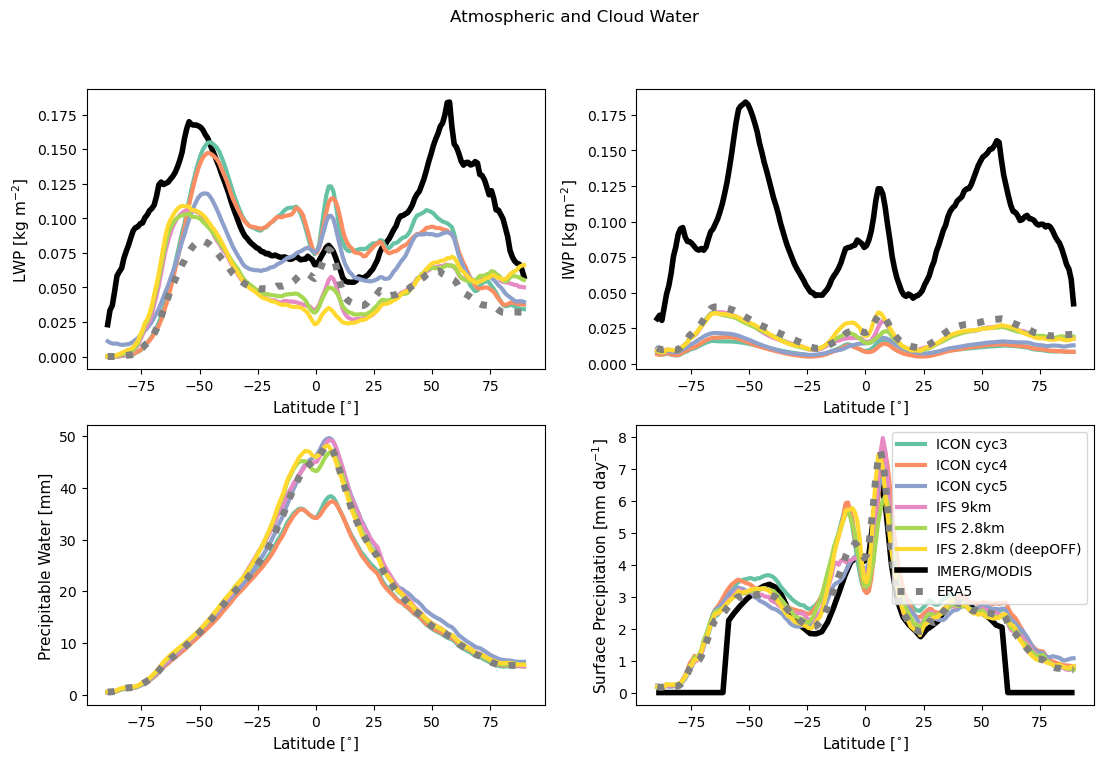

In [63]:
plot_lat_profiles(['cllvi', 'clivi', 'prw', 'pr'], 'Atmospheric and Cloud Water', 
                  obs_source={'cllvi': 'MODIS', 'clivi': 'MODIS','pr':'IMERG'})

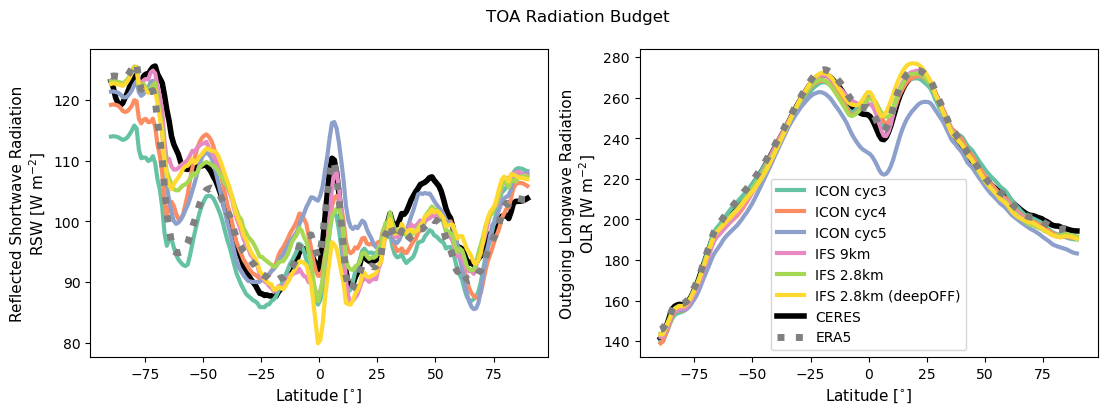

In [64]:
plot_lat_profiles(['rsut', 'rlut'], 'TOA Radiation Budget', obs_source={'rsut': 'CERES', 'rlut': 'CERES'})